In [1]:
from IPython.display import HTML

In [2]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aim-of-notebook" data-toc-modified-id="Aim-of-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aim of notebook</a></span></li><li><span><a href="#Constants-and-settings" data-toc-modified-id="Constants-and-settings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Constants and settings</a></span></li><li><span><a href="#Producing-the-plots" data-toc-modified-id="Producing-the-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Producing the plots</a></span></li><li><span><a href="#Querying-the-plots" data-toc-modified-id="Querying-the-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Querying the plots</a></span></li></ul></div>

# Aim of notebook
This notebook is an interface for us to see ME plots. 
- First, many possible plots must be generated and stored as images with filenames containing the nominal stimulus parameter values.
- Then, a simple function needs to be written that will allow the user to specify a cylinder set in parameter space, thereby fetching the relevant plots.

# Constants and settings

In [3]:
import sys

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# add location of data to path -- I couldn't make this work
# sys.path.insert(0,'../../data/')
# sys.path.insert(0,'../modules/dots_db/data/')

In [4]:
# pip modules
import pprint
import numpy as np             
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
import h5py     

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

In [5]:
# OPTIONS AND CONSTANTS
%matplotlib inline

sns.set(style="darkgrid", context="poster")
TITLE_FS = 22
AXES_FS = 22
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels

SKIP_BASIC_STEPS = False

<Figure size 432x288 with 0 Axes>

Load all group and dataset names in DB

In [6]:
file_path = '/home/adrian/SingleCP_DotsReversal/processed/pilot_v3.h5'
obj_names, db_info = my_me.get_object_names_in_db(file_path)

In [7]:
print('first 4 names in database (as an example)')
pprint.pprint(obj_names[:4])

first 4 names in database (as an example)
['subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/left/px',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right',
 'subjS1/probCP0.0/coh0.0/ansleft/CPno/VD100/right/px']


# Producing the plots

Let's first write a function that takes as input an elementary cylinder set (singleton) and returns a `pandas.Series` amenable to ME plotting (where the difference between R and L answers has already been computed). 

In [8]:
def compute_ME_diff(cylinder, object_names, uniform_shape, database_info):
    """
    A cylinder looks like this:
    cylinder = {'coh': [0], 'vd': [400], 'cp': [False]}
    
    """
    r_cylinder, l_cylinder = cylinder.copy(), cylinder.copy()
    r_cylinder['ans'], l_cylinder['ans'] = 'r', 'l'
    
    r_group_names, r_dset_names = my_me.get_names(r_cylinder, object_names)
    l_group_names, l_dset_names = my_me.get_names(l_cylinder, object_names)
    
    r_dots = my_me.extract_list_arrays(r_group_names, r_dset_names, uniform_shape, file_path)
    l_dots = my_me.extract_list_arrays(l_group_names, l_dset_names, uniform_shape, file_path)

    # truncate to minimum number of frames (left time-alignment)
    min_num_frames = min(min(r_k.shape[2], l_k.shape[2]) for r_k, l_k in zip(r_dots, l_dots))

    r_dots = [d[:,:,:min_num_frames] for d in r_dots]
    l_dots = [d[:,:,:min_num_frames] for d in l_dots]

    r_agg_df = my_me.build_me_df(database_info, r_group_names, r_dots, r_cylinder)
    l_agg_df = my_me.build_me_df(database_info, l_group_names, l_dots, l_cylinder)
    
    righties = r_agg_df.groupby('time').mean()
    lefties = l_agg_df.groupby('time').mean()
    
    final = righties['ME'] - lefties['ME']
    return final

In [9]:
cyl = {'coh': [0], 'vd': [400], 'cp': [False]}
d = compute_ME_diff(cyl, obj_names, 50, db_info)

In [19]:
def print_cyl(cyl):
    base = ''
    for k,v in cyl.items():
        base += k + ':'
        for vv in v:
            base += str(vv) + '-'
        base = base[:-1]  # delete trailing -
        base += ' '
    return base

In [20]:
print_cyl(cyl)

'coh:0 vd:400 cp:False '

Text(0.5, 1.0, 'coh:0 vd:400 cp:False ')

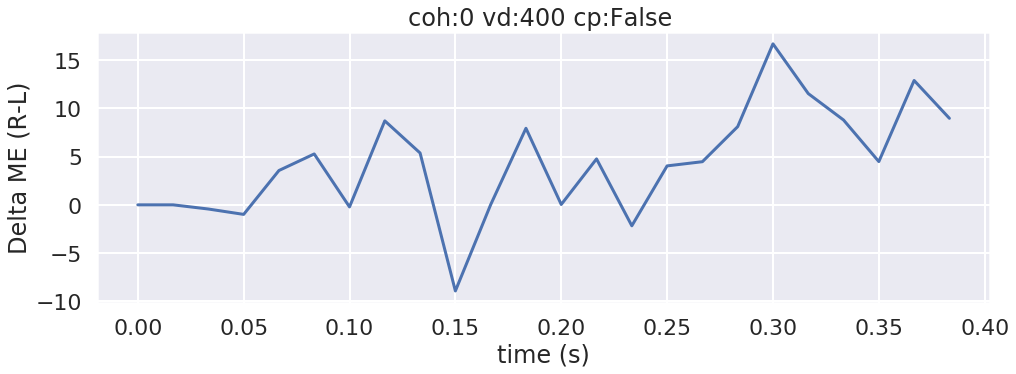

In [21]:
plt.rcParams["figure.figsize"] = (16, 5) # (w, h) # figure size 
plt.plot(d)
plt.ylabel('Delta ME (R-L)')
plt.xlabel('time (s)')
plt.title(print_cyl(cyl))

# Querying the plots